<a href="https://colab.research.google.com/github/WittmannF/DL-plagiarism-detector/blob/master/Plagiarism_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. TODO: Import any additional packages
from keras.models import Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50

TARGET_SHAPE = (224, 224, 3)

# 2. TODO: Initialize base model
base_model = ResNet50(include_top=False, input_shape=TARGET_SHAPE)

# 3. TODO: Freeze layers from the base model
for layer in base_model.layers:
    layer.trainable=False
    
# 4. TODO: Add Fully connected layer to the base model
model = Sequential([base_model,
                    GlobalAveragePooling2D()])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
import numpy as np
import requests
from io import BytesIO
from PIL import Image

In [0]:
URLS = ['https://upload.wikimedia.org/wikipedia/commons/6/66/An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg',
        'https://images.pexels.com/photos/20787/pexels-photo.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/9/9e/Tabby_cat-3337027.jpg',
        'https://images.pexels.com/photos/162349/dog-hybrid-animal-lying-162349.jpeg',
        'https://images.pexels.com/photos/356378/pexels-photo-356378.jpeg']

target_shape=(224,224)

In [0]:
def read_img_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_shape)
    return img

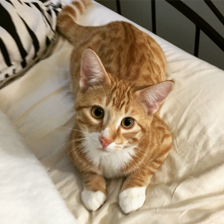

In [13]:
img = read_img_url(URLS[0]); img

In [0]:
from keras.applications.resnet50 import preprocess_input

def preprocess_img(img):
    # Convert to a Numpy array
    img_np = np.asarray(img)

    # Reshape by adding 1 in the beginning to be compatible as input of the model
    img_np = img_np[None] # https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#numpy.newaxis

    # Prepare the image for the model
    img_np = preprocess_input(img_np)
    
    return img_np

In [0]:
img_np = preprocess_img(img)

In [0]:
result = model.predict(img_np)

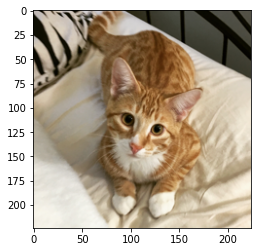

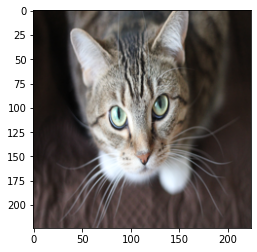

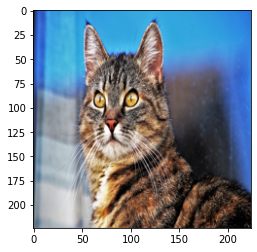

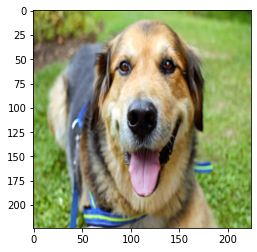

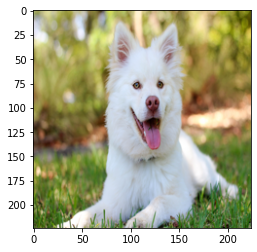

In [26]:
import matplotlib.pyplot as plt

all_features = []

for url in URLS:
    img = read_img_url(url)
    plt.imshow(img)
    plt.show()
    img_np = preprocess_img(img)
    result = model.predict(img_np)
    all_features.append(result[0])

In [29]:
import pandas as pd

df = pd.DataFrame(all_features); df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.042308,0.168865,0.034707,0.282211,0.273753,0.063503,0.329372,0.401481,0.299975,0.019311,0.287234,0.187533,0.334624,0.333550,0.177318,0.121659,0.012154,0.026436,0.153946,0.053217,0.072000,0.122551,0.042426,0.397307,0.481875,0.108170,0.311271,0.036436,0.057051,1.210866,0.201918,1.845439,0.014216,0.095395,2.725238,0.215707,0.093478,0.681401,0.012105,0.191334,...,0.000000,0.007023,1.158018,0.000000,0.945266,0.027128,0.397069,2.091383,0.159090,0.010994,0.000000,0.000000,0.000000,1.335536,0.037237,0.199467,0.469527,2.574245,0.231526,0.133946,0.595770,0.007868,0.194367,0.221116,2.208642,0.227523,0.418293,0.058154,0.000000,0.101071,0.023131,0.047329,0.000000,2.145496,0.043495,0.553697,0.151877,0.133250,0.027247,0.199385
1,0.025938,0.364023,0.002671,0.121978,0.157954,0.359916,0.182206,0.270348,0.000000,0.000000,0.000000,0.000000,0.069450,0.076153,0.024985,0.000000,0.122439,0.003567,0.273841,0.146902,0.249745,0.010659,0.000000,0.718277,0.014272,0.073362,0.616622,0.016031,0.000000,0.000000,0.203763,0.164111,0.007428,0.161543,0.511678,0.082609,0.003743,0.784711,0.805828,0.216602,...,0.191724,0.000000,0.610750,0.037134,0.000000,0.142060,0.310176,0.196507,0.939605,0.227696,0.000000,0.000000,0.002796,1.779072,0.001015,0.358017,0.281408,0.040701,0.002146,0.004344,0.281539,0.000000,0.166622,0.000000,0.330221,0.000000,0.078642,0.373150,0.091342,0.284855,0.010499,0.384191,0.037875,0.991623,0.001638,0.066376,0.583706,0.000000,0.022262,0.158811
2,0.315768,0.049677,0.072736,0.029473,0.194881,0.000000,0.263104,0.378804,0.000000,0.199715,0.009670,0.006166,0.466496,0.006648,0.154985,0.000000,0.135079,0.000000,0.157396,0.202456,0.000000,0.133431,0.000000,0.295435,0.197056,0.015042,0.119953,0.126033,0.004000,0.079121,0.114987,1.128978,0.000000,0.032939,0.542522,0.125414,0.000000,1.011145,0.591465,0.171527,...,0.224916,0.065314,0.857295,0.229519,0.187825,0.000000,0.240743,1.117852,0.074505,0.152508,0.486728,0.009316,0.000000,0.013623,0.982027,0.008490,1.910821,0.034408,0.073114,0.026375,0.725586,0.063366,0.339266,0.024320,0.436376,0.000000,0.000000,0.004838,0.000000,0.092685,0.075172,0.000000,0.337389,0.343541,0.165771,0.064158,1.313954,0.000000,0.140156,0.000000
3,0.439888,0.076697,0.012772,0.000000,0.019944,2.500911,0.270587,0.403028,0.007690,0.442542,0.045540,0.015771,2.599114,0.275431,0.000000,0.239130,0.000000,0.935476,0.125230,0.034047,1.543936,0.054890,0.371684,0.599665,0.098614,0.008500,0.006772,0.885238,0.000000,0.404353,0.702676,0.135913,0.037729,0.711778,0.033072,0.015717,0.000000,0.158277,0.535844,0.376901,...,0.054220,1.173569,0.089450,0.075139,0.637120,0.047043,0.308179,0.101238,0.168777,0.141622,0.018883,0.054504,0.054495,0.000000,0.180436,0.036910,0.266209,0.181483,0.070275,1.340660,0.627921,0.000000,0.042656,0.264619,0.065561,0.062744,0.612002,0.014584,0.410401,0.041458,0.334218,0.394886,0.010589,0.031647,0.210968,0.191819,0.093776,0.113848,0.268616,0.283168
4,0.537157,0.219324,0.081363,0.416222,0.124936,0.204497,0.000000,0.067160,0.214189,0.214841,0.030703,0.094725,0.466140,0.000000,0.010587,0.000000,0.000000,1.118436,0.246646,0.000000,0.000000,0.001567,0.524867,0.302005,0.050315,0.293311,0.014463,0.079879,0.081266,0.056639,1.059674,0.622229,0.209047,0.665587,0.173117,0.009413,0.000000,0.152467,2.043540,0.000000,...,1.114734,0.481417,1.034750,0.000000,0.000000,0.468662,0.016597,0.653945,0.082562,0.000000,0.012267,0.127353,0.095275,0.056274,0.328922,0.082574,2.399606,0.000000,0.000000,2.954933,0.321786,0.000000,0.351217,0.000000,1.912971,0.000428,0.085345,0.021195,0.000000,0.230685,0.182890,0.797268,0.059969,0.548853,0.126000,0.106490,1.265144,0.023760,0.515167,0.064750


## PCA

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
reduced_data = pca.transform(df)

In [0]:
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [34]:
reduced_data

,Dimension 1,Dimension 2
0,-10.871898,17.540184
1,-13.253351,-6.396704
2,-9.605894,-11.273940
3,17.588707,-3.101003
4,16.142435,3.231463


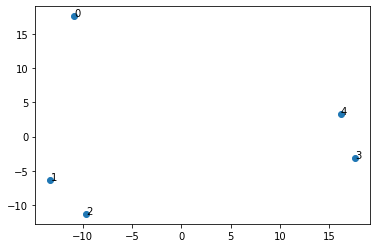

In [42]:
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'])

for item in reduced_data.itertuples():
    plt.annotate(item[0], (item[1], item[2]))
    

### Conclusion
The X Axis turned to be what differentiates dogs and cats. Apparently dogs will be in the right and cats in the left. The Y axis seems to be related to the color, since cat at index 0 has a different color when compared to the cat at index 1 and 2. This can also be confirmed because cat at index 1 has a very similar color to the dog at index 3. 

## More Cats and Dogs
Based on https://github.com/WittmannF/course/blob/master/day-4/assignment-3-cats-dogs-solved.ipynb

In [44]:
import os

DATA_PATH = 'cats-dogs-data/'
DATA_URL = 'https://github.com/dl7days/datasets/raw/master/cats-dogs-data.zip'
ZIP_FILENAME = 'cats-dogs-data.zip'

if not os.path.exists(DATA_PATH):# If dataset folder doesn't exist
    try: # Then try downloading and unzipping it
        print("Downloading Dataset...")
        os.system(f"wget {DATA_URL}")

        print("Unzipping Dataset")
        os.system(f"unzip {ZIP_FILENAME}")

        print("Removing .zip file")
        os.system(f"rm {ZIP_FILENAME}")
    except Exception as e: # If there's an error, ask to download manually
        print(f"Something went wrong. Please download the dataset manually at {DATA_URL}")
        print(f'The following exception was thrown:\n{e}')
else:
    print(f'Dataset folder {DATA_PATH} has been found')

Unzipping Dataset
Removing .zip file


In [0]:
# Assign training and validation folders
TRAIN_PATH = f'{DATA_PATH}train/'
VALID_PATH = f'{DATA_PATH}valid/'

In [0]:
import glob

filepaths = glob.glob(TRAIN_PATH+'/cat/*.jpg')
for f in glob.glob(TRAIN_PATH+'/dog/*.jpg'):
    filepaths.append(f)

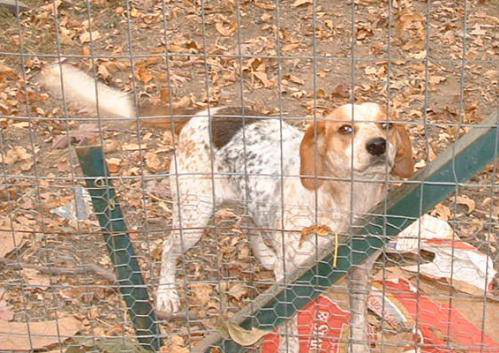

In [48]:
from keras.preprocessing.image import load_img
import random

load_img(random.choice(filepaths))

In [49]:
# TODO: Import the model and the preprocess_input function
from keras.applications.resnet50 import ResNet50, preprocess_input

# TODO: Import the ImageDataGenerator class
from keras.preprocessing.image import ImageDataGenerator

# Shape in which all images are going to be reshaped
TARGET_SHAPE = (224, 224, 3)

# TODO: Initialize the data generator class 
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# TODO: Create the training and validation generators using the method flow_from_directory
train_gen = datagen.flow_from_directory(TRAIN_PATH, target_size=TARGET_SHAPE[:2], class_mode='sparse')
valid_gen = datagen.flow_from_directory(VALID_PATH, target_size=TARGET_SHAPE[:2], class_mode='sparse')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [52]:
all_predictions = model.predict_generator(valid_gen, verbose=1)

13/13 [==============================] - 79s 6s/step


In [0]:
df = pd.DataFrame(all_predictions)

In [0]:
y = valid_gen.classes

In [61]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df)
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

reduced_data.head()

,Dimension 1,Dimension 2
0,9.463359,-3.505127
1,-13.346521,4.691217
2,2.615883,2.532768
3,-7.910217,-2.413325
4,-4.542747,-2.288956


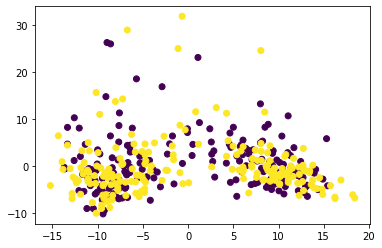

In [62]:
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=y)

### Conclusion
When generalizing to multiple images, it was not able to reduce into only 2 dimensions in a way that distinguishes cats and dogs. Let's try T-SNE

In [63]:
from sklearn.manifold import TSNE
reduced_data = TSNE(n_components=2).fit_transform(df)
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

reduced_data.head()

,Dimension 1,Dimension 2
0,13.093875,12.758947
1,-5.827660,-17.736099
2,0.083663,-0.408250
3,-7.817942,-13.603868
4,-3.681872,-13.511813


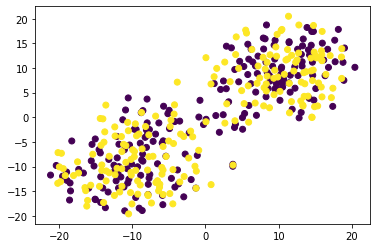

In [65]:
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=y)

### Conclusion
It seems many features are extracted which does not really make predominant the feature which distinguishes cats vs dogs. So, it might not be enough to use a feature extractor

### Next Attempt, GaussianMixture

In [68]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
range_components = [2,3,4,5,6,7,8,9,10]

for n_components in range_components:
# TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components, covariance_type='full')
    clusterer.fit(df)

# TODO: Predict the cluster for each data point
    preds = clusterer.predict(df)

# TODO: Find the cluster centers
    centers = clusterer.means_

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = score = silhouette_score(df, preds)
    print ("Silhouette coefficient for {} clusters: {:.3f}".format(n_components, score))

Silhouette coefficient for 2 clusters: 0.097
Silhouette coefficient for 3 clusters: 0.077
Silhouette coefficient for 4 clusters: 0.055
Silhouette coefficient for 5 clusters: 0.062
Silhouette coefficient for 6 clusters: 0.083
Silhouette coefficient for 7 clusters: 0.074
Silhouette coefficient for 8 clusters: 0.053
Silhouette coefficient for 9 clusters: 0.016
Silhouette coefficient for 10 clusters: 0.029


In [70]:
n_components=2

# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(n_components, covariance_type='full')
clusterer.fit(df)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(df)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(df, preds)
print ("Silhouette coefficient for {} clusters: {:.3f}".format(n_components, score))

Silhouette coefficient for 2 clusters: 0.097


In [71]:
preds

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [72]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [74]:
np.mean(preds==y)

0.49

### Conclusion
Reviewing another time, but something is not right. Apparently the features that are being extracted are completelly random and does not inform anything related to wheter it is a cat or a dog. 

If everything is correct, maybe what is happening is that just one column or two that are relevant to distinguish Cats vs Dogs. Hence, it is necessary something to tell which columns are those. Let's try a random forest:

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
clf = RandomForestClassifier(random_state=0)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=0)

In [81]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [82]:
clf.score(X_test, y_test)

0.47

No success again. Hence, there might be something wrong with the feature extractor. Checking again another time (when I get inspired again).